##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Neural style transfer

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/generative/style_transfer"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/style_transfer.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/style_transfer.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/generative/style_transfer.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

This tutorial uses deep learning to compose one image in the style of another image (ever wish you could paint like Picasso or Van Gogh?). This is known as *neural style transfer* and the technique is outlined in <a href="https://arxiv.org/abs/1508.06576" class="external">A Neural Algorithm of Artistic Style</a> (Gatys et al.). 

Note: This tutorial demonstrates the original style-transfer algorithm. It optimizes the image content to a particular style. Modern approaches train a model to generate the stylized image directly (similar to [CycleGAN](./cyclegan.ipynb)). This approach is much faster (up to 1000x).

For a simple application of style transfer with a pretrained model from [TensorFlow Hub](https://tfhub.dev), check out the [Fast style transfer for arbitrary styles](https://www.tensorflow.org/hub/tutorials/tf2_arbitrary_image_stylization) tutorial that uses an [arbitrary image stylization model](https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2). For an example of style transfer with [TensorFlow Lite](https://www.tensorflow.org/lite), refer to [Artistic style transfer with TensorFlow Lite](https://www.tensorflow.org/lite/examples/style_transfer/overview).

Neural style transfer is an optimization technique used to take two images—a *content* image and a *style reference* image (such as an artwork by a famous painter)—and blend them together so the output image looks like the content image, but “painted” in the style of the style reference image.

This is implemented by optimizing the output image to match the content statistics of the content image and the style statistics of the style reference image. These statistics are extracted from the images using a convolutional network.

In [2]:
import os
import tensorflow_hub as hub
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In [3]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools
from os import walk
import time

In [4]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [5]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

Create a simple function to display an image:

In [6]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

In [7]:
## Get lists that store the file names for content and style pictures 

# folder path
dir_path = './unsplash-images-collection'

# list to store files name
allImagesContent = []
for (dir_path, dir_names, file_names) in walk(dir_path):
    print(dir_path)
    allImagesContent.extend(file_names)
#print(allImagesContent)


dir_path = './Art/resized/resized/'

# list to store files name
allImagesStyle = []
for (dir_path, dir_names, file_names) in walk(dir_path):
    print(dir_path)
    allImagesStyle.extend(file_names)
#print(allImagesStyle)


./unsplash-images-collection
./Art/resized/resized/



input_1
rescaling
normalization
rescaling_1
stem_conv_pad
stem_conv
stem_bn
stem_activation
block1a_dwconv
block1a_bn
block1a_activation
block1a_se_squeeze
block1a_se_reshape
block1a_se_reduce
block1a_se_expand
block1a_se_excite
block1a_project_conv
block1a_project_bn
block2a_expand_conv
block2a_expand_bn
block2a_expand_activation
block2a_dwconv_pad
block2a_dwconv
block2a_bn
block2a_activation
block2a_se_squeeze
block2a_se_reshape
block2a_se_reduce
block2a_se_expand
block2a_se_excite
block2a_project_conv
block2a_project_bn
block2b_expand_conv
block2b_expand_bn
block2b_expand_activation
block2b_dwconv
block2b_bn
block2b_activation
block2b_se_squeeze
block2b_se_reshape
block2b_se_reduce
block2b_se_expand
block2b_se_excite
block2b_project_conv
block2b_project_bn
block2b_drop
block2b_add
block3a_expand_conv
block3a_expand_bn
block3a_expand_activation
block3a_dwconv_pad
block3a_dwconv
block3a_bn
block3a_activation
block3a_se_squeeze
block3a_se_reshape
block3a_se_reduce
block3a_se_expand
bl

[('cab', 0.16215827),
 ('cinema', 0.076413624),
 ('street_sign', 0.05358799),
 ('streetcar', 0.053535145),
 ('jinrikisha', 0.03891314)]

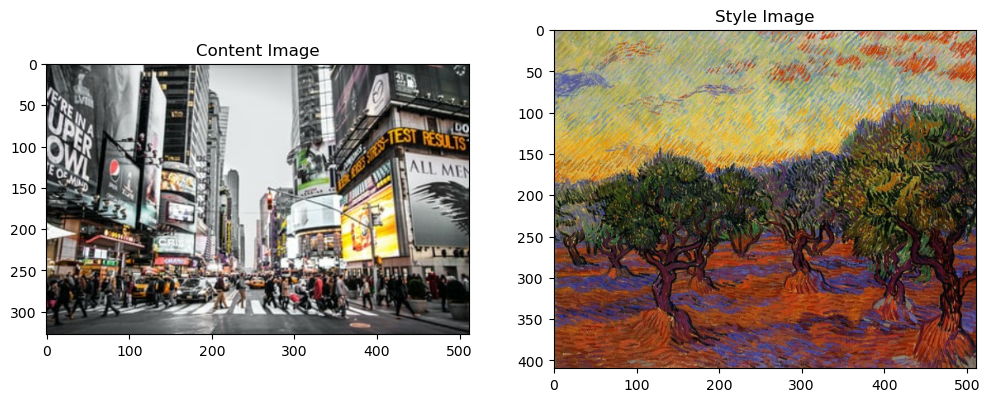

In [8]:
# Print the layers of MobileNet
efficient_net = tf.keras.applications.EfficientNetB0(include_top=True, weights='imagenet')

print()
for layer in efficient_net.layers:
  print(layer.name)

# Load a content and a style image for testing
content_image = load_img("unsplash-images-collection/photo-1529218402470-5dec8fea0761.jpg")
style_image = load_img("Art/resized/resized/Vincent_van_Gogh_288.jpg")

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')
# Testing if the imported architecture works correctly
x = tf.keras.applications.efficientnet.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
efficient_net = tf.keras.applications.EfficientNetB0(include_top=True, weights='imagenet')
prediction_probabilities = efficient_net(x)
prediction_probabilities.shape
print(content_image.shape)

predicted_top_5 = tf.keras.applications.efficientnet.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]


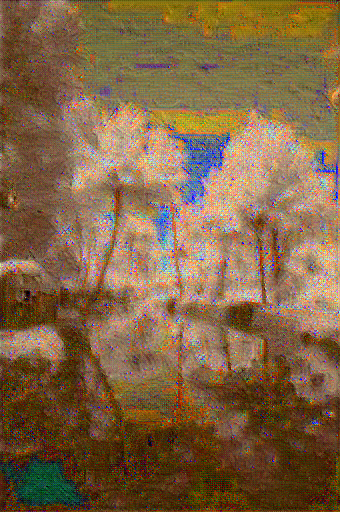

Train step: 200
Total time: 225.8


In [14]:
start = time.time()

epochs = 5#5
steps_per_epoch = 40#60

for i in range(1): #allImagesContent
    counter = 0
    
    # Change this to + i if you want all of the pictures
    
    ##Change
    test_content = load_img('./unsplash-images-collection/photo-1541958409-7618fd1ad26e.jpg')
    display.display(tensor_to_image(test_content))
    
    
    for j in range(1): #allImagesStyle
        
        test_style = load_img('./Art/resized/resized/Pablo_Picasso_54.jpg')
        
        x = tf.keras.applications.efficientnet.preprocess_input(test_content*255)
        x = tf.image.resize(x, (224, 224))
        # Exclude the fully connected layers
        efficient_net = tf.keras.applications.EfficientNetB0(include_top=False, weights='imagenet')
        
        # Information from where we are extracting the Information out
        content_layers = ['top_activation'] 

        style_layers = ['block1a_activation',
                       'block3b_activation',
                        'block4c_activation',
                        'block5c_activation',
                       'block7a_activation']

        num_content_layers = len(content_layers)
        num_style_layers = len(style_layers)
        
        ## Why do we need this?
        def efficient_net_layers(layer_names):
          """ Creates a EfficientNet model that returns a list of intermediate output values."""
          # Load our model. Load pretrained EfficientNet, trained on ImageNet data
          efficient_net = tf.keras.applications.EfficientNetB0(include_top=False, weights='imagenet')
          efficient_net.trainable = False

          outputs = [efficient_net.get_layer(name).output for name in layer_names]

          model = tf.keras.Model([efficient_net.input], outputs)
          return model
    
        style_extractor = efficient_net_layers(style_layers)
        style_outputs = style_extractor(test_style*255)
        
        ## Compute the gram Matrix
        def gram_matrix(input_tensor):
          result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
          input_shape = tf.shape(input_tensor)
          num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
          return result/(num_locations)
        
        ## Compute the style and Content outputs for a give image
        class StyleContentModel(tf.keras.models.Model):
          def __init__(self, style_layers, content_layers):
            super(StyleContentModel, self).__init__()
            self.efficientnet = efficient_net_layers(style_layers + content_layers)
            self.style_layers = style_layers
            self.content_layers = content_layers
            self.num_style_layers = len(style_layers)
            self.efficientnet.trainable = False

          def call(self, inputs):
            "Expects float input in [0,1]"
            inputs = inputs*255.0
            preprocessed_input = tf.keras.applications.efficientnet.preprocess_input(inputs)
            outputs = self.efficientnet(preprocessed_input)
            style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                              outputs[self.num_style_layers:])

            style_outputs = [gram_matrix(style_output)
                             for style_output in style_outputs]

            content_dict = {content_name: value
                            for content_name, value
                            in zip(self.content_layers, content_outputs)}

            style_dict = {style_name: value
                          for style_name, value
                          in zip(self.style_layers, style_outputs)}

            return {'content': content_dict, 'style': style_dict}
        
        ## Uses the Style Model
        extractor = StyleContentModel(style_layers, content_layers)


        style_targets = extractor(test_style)['style']
        content_targets = extractor(test_content)['content']

        results = extractor(tf.constant(test_content))
        
        image = tf.Variable(test_content)
        
        def clip_0_1(image):
            return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)
        
        
        opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
        
        style_weight=1e8
        content_weight=1e-2
        
        ## Compute the losses for the style and the content
        def style_content_loss(outputs):
            style_outputs = outputs['style']
            content_outputs = outputs['content']
            style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                                   for name in style_outputs.keys()])
            style_loss *= style_weight / num_style_layers

            print("Style loss")
            print(style_loss)

            content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                                     for name in content_outputs.keys()])

            print("Content loss")
            content_loss *= content_weight / num_content_layers
            print(content_loss)
            loss = style_loss + content_loss
            return loss
        
        total_variation_weight=1
        
        
        ## Make Gradient Descent
        @tf.function()
        def train_step(image):
          with tf.GradientTape() as tape:
            outputs = extractor(image)
            loss = style_content_loss(outputs)
            print("Total")
            print(type(loss))
            loss += total_variation_weight*tf.image.total_variation(image)

          grad = tape.gradient(loss, image)
          opt.apply_gradients([(grad, image)])
          image.assign(clip_0_1(image))
        
        display.display(tensor_to_image(test_style))

        step = 0
        for n in range(epochs):
          for m in range(steps_per_epoch):
            step += 1
            train_step(image)
            print()
            print(".", end='', flush=True)
          display.clear_output(wait=True)
          display.display(tensor_to_image(image))
          print("Train step: {}".format(step))
          ## Save Image
          file_name = 'Efficient_net_'+'stylized-image'+str(n)+'.png'
          tensor_to_image(image).save(file_name)
        
        end = time.time()
        print("Total time: {:.1f}".format(end-start))
        
        ## Save Image
        file_name = 'stylized-image.png'
        tensor_to_image(image).save(file_name)